# Projeto 2 - Parte II -  Classificação

Esse notebook tem como objetivo explorar os algoritmos de aprendizado supervisionado para a classificação em cima do dataset Pen-Based Recognition of Handwritten Digits Data Set. 


O andamento dessa parte do projeto vai seguir de acordo com as seguintes seções:
* [Load dataset](#title1)
* [Data split](#title2)
* [Pre-processing](#title3)
* [Vizualization](#title4)
* [Training Logistic Regression Multiclass](#title5)
* [Training OneVsOne Classifier](#title6)
* [Evaluation Logistic Regression Multiclass](#title7)
* [Evaluation OneVsOne Classifier](#title8)
* [Test Logistic Regression Multiclass](#title9)
* [Test OneVsOne Classifier](#title10)

### Load Dataset <a name="title1" />

Primeiramente vamos importar as bibliotecas importantes para essa parte do trabalho

In [1]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import load_digits

Em seguida, iremos carregar o nosso dataset e viualizar algumas informações básicas sobre ele, como o seu formato e suas colunas

In [2]:
digits = load_digits()
data = pd.DataFrame(data= np.c_[digits['data'], digits['target']],
                     columns= digits['feature_names'] + ['target'])

In [3]:
print("Shape", data.shape)

Shape (1797, 65)


In [4]:
data.columns

Index(['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4',
       'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1',
       'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6',
       'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3',
       'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0',
       'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5',
       'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2',
       'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7',
       'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4',
       'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1',
       'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6',
       'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3',
       'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7', 'target'],
      dtype='object')

In [5]:
print("First line")
data.iloc[0]

First line


pixel_0_0     0.0
pixel_0_1     0.0
pixel_0_2     5.0
pixel_0_3    13.0
pixel_0_4     9.0
             ... 
pixel_7_4    10.0
pixel_7_5     0.0
pixel_7_6     0.0
pixel_7_7     0.0
target        0.0
Name: 0, Length: 65, dtype: float64

Uma informação muito importante é entendermos a distibuição de classes no dataset que como podemos ver abaixo é bem próxima para todas elas

<AxesSubplot:>

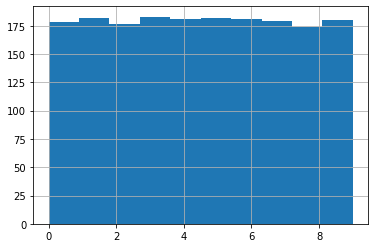

In [6]:
data['target'].hist()

Como podemos ver o nosso dataset apresenta classes relativamente bem balanceadas, dessa forma não será performado nada que busque equilibra-las

### Data Split <a name="title2" />

Agora vamos divir nossos dados para treino e teste seguindo a proporção de 90/10, usando a biblioteca train_test_split com random_state fixado, sendo que esses 10% de teste só serão usados no final para avalair o desempenho dos modelos. Sendo assim, como resultado de nossa divisão temos a seguinte separação:

In [7]:
train, test = train_test_split(data, test_size=0.1,  random_state=1)
print("Train shape", train.shape)
print("Test shape", test.shape)

Train shape (1617, 65)
Test shape (180, 65)


Abaixo nota-se a proporção de classes entre treino e teste, a de treino parece relativamente balanceada, mas a de teste, pela menor quantia, fica mais evidente a discrêpancia entre as classes presentes

<AxesSubplot:>

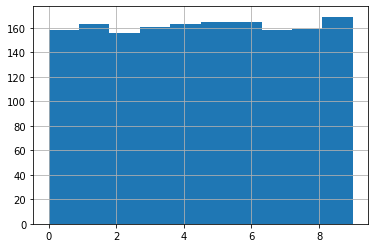

In [8]:
train['target'].hist()

<AxesSubplot:>

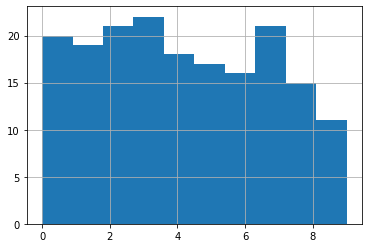

In [9]:
test['target'].hist()

In [10]:
x_train = train.loc[:, train.columns != 'target']
y_train = train['target']
x_test = test.loc[:, test.columns != 'target']
y_test = test['target']
print("Train dimensiom:", x_train.shape, y_train.shape)
print("Test dimensiom:", x_test.shape, y_test.shape)

Train dimensiom: (1617, 64) (1617,)
Test dimensiom: (180, 64) (180,)


Para o treino com validação será usado a estratégia de KFold, com 4 folds, sendo assim, o set de treino será dividido em 4 grupos que se revezarão sequencialmente para servir de validação para o modelo, dessa forma todos os dados do treino em algum momento vão ser usados para validação

In [11]:
kf = KFold(n_splits=4, shuffle=True, random_state= 11)
print(kf)
kf.get_n_splits(train)

KFold(n_splits=4, random_state=11, shuffle=True)


4

### Pre-processing <a name="title3" />

Aqui será feita a normalização das features, foi usada a normalização l2, que leva em consideração a distância euclidiana, a opção foi escolhida por ter sido visto, em alto nível, que essa regularização favorece a um resultado único.

In [12]:
from sklearn.preprocessing import normalize
x_train = normalize(x_train, norm = "l2")
print(x_train.max(), x_train.min())
x_test = normalize(x_test, norm = "l2")
print(x_test.max(), x_test.min())

0.3183488677277356 0.0
0.32031106631923656 0.0


### Vizualization <a name="title4" />

Para mostrar uma vizualização bidimensional de como se comporta a separação entre as classes foi usada a técnica TSNE, que consite em uma redução dimensional capaz de achar conexões não lineares, pela probabilidade de distribuição de vizinhos ao redor de cada ponto (pessoalmente achei bem confuso sobre, acharia interessante se fosso compartilhado mais material sobre =)

Como é possível ver abaixo parece haver alguns outliars de algumas classes mas o número 9 em especial se destaca por aparece em diversos pontos distintos da figura

Sobre o TSNE, tive como a melhor fonte para compreender esse artigo: https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a

In [13]:
from sklearn.manifold import TSNE
train_embedded = TSNE(n_components=2, random_state=11).fit_transform(x_train)
train_embedded.shape

(1617, 2)

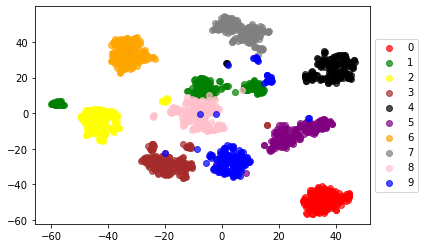

In [14]:
import matplotlib.pyplot as plt
colors = ["red", "green", "yellow", "brown", "black", "purple", "orange", "gray", "pink", "blue"]
color_by_target = []
fig, ax = plt.subplots()
for i in range(10):
    color_i = []
    for j in range(1617):
        if list(y_train)[j] == i:
            color_i.append(train_embedded[j])
    color_by_target.append(color_i)
for i in range(10):
    for j in range(len(color_by_target[i])):
        if j == 0:
            ax.scatter(color_by_target[i][j][0] , color_by_target[i][j][1] , color = colors[i], alpha=0.7, label=str(i))
        else:
            ax.scatter(color_by_target[i][j][0] , color_by_target[i][j][1] , color = colors[i], alpha=0.7)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Training and Evaluation Logistic Regression Multiclass <a name="title5" />

O primeiro algoritmo escolhido foi a Regressão Logistica Multiclass, vista anteriormente em aula, para implemnta-la foi usada a função do scikit-learn. O objetivo nesse momento é testar diversos modelos com diversos hierparametros e avalia-los para escolher o melhor. A avaliação para buscar o melhor modelo foi por conta da acurácia, mas também é demonstrada o F1 score de cada modelo para o conjunto de validação. Nessa seção foram variados os seguintes hiperparâmetros: penalty, solvers e max_iter

Para penalidade existem as seguintes opções: l1, l2 e none. Comparando os resultados obtidos nota-se que esse hiperparametro não modifica muito no resultado, nem todas penalidades podem ser usadas com as combinações de outros hiperparametros.

Para solvers há as seguintes opções:
- lbfgs (Limited-memory Broyden–Fletcher–Goldfarb–Shanno):algoritmo de otimização derivado do BFGS, que usa a inversa de uma aproximação implícita da matriz  para encontrar um mínimo local
- newton-cg: variação do método de Newton para grande quantidade de dimensões, tende a convergir mais rápido para funções quadráticas
- sag:  algortimo de otimização em que gradiente da perda é estimado a cada amostra por vez e o modelo é atualizado ao longo do caminho com uma taxa de aprendizado constante, possui o desempenho mais rápido para datasets grandes (fonte: https://www.kite.com/python/docs/sklearn.linear_model.sag.sag_solver#:~:text=SAG%20solver%20for%20Ridge%20and,are%20on%20the%20same%20scale.)
- saga: variação do sag que aceita penalty l1

A principal diferneça entre os solvers é que alguns só aceitam certas penalidades, a acurácia e o f1score foi muito semelhante entre todos, provavelmente a principal diferença é o tempo que cada um leva para convergir, para explorar isso expõe-se abaixo um treino variando somente os solvers e mostrando o tempo de execução para cada um

In [15]:
from sklearn.linear_model import LogisticRegression
import warnings
import time 

warnings.filterwarnings('ignore')
for s in ['lbfgs', 'newton-cg', 'sag', 'saga']:
    for train_set, val_set in kf.split(train):
        inicio = time.time()
        clf_lr = LogisticRegression(multi_class='multinomial',
                penalty='l2', #lasso regression
                solver=s,
                max_iter=100,
                C=10).fit(x_train[train_set], y_train.iloc[train_set])
    fim = time.time()
    print(s, fim - inicio)


lbfgs 0.23836016654968262
newton-cg 0.203171968460083
sag 0.30617427825927734
saga 0.48233723640441895


Além desses houve a variação do parametro max_iter , que é o numero máximo de iterações para que o modelo convirga, entre os valores [1, 10, 100, 1000, 10000]. No geral a mudança mais perceptiva é entre 1 e 10 iterações, que há um aumento muito significativo entre os valores (como esperado). Para a maior parte das variações acima disso ou há um leve aumento ou fica continuo pois o modelo já covnergiu

Por fim, o último parametro é o C, que é a intensidade inversa da regularização, um elemento importantissimo para o controle de underfit e overfit, sendo variado entre [0.01, 0.1, 1, 10, 100].  É possível notar que para os valores mais baixos os resultados, provavelmente por conta de underfit

In [16]:
import warnings
from sklearn.metrics import accuracy_score, f1_score
warnings.filterwarnings('ignore')

penalty = ['l2', 'none', 'l1']
solvers = ['lbfgs', 'newton-cg', 'sag', 'saga']
c = [0.01, 0.1, 1, 10, 100]
max_iter = [1, 10, 100, 1000, 10000]
models = []
acurr_total = []
f1score_total = []
index = 0
max_score = 0
max_index = 0
for p in penalty:
    print(p)
    for s in solvers:
        if (s == 'lbfgs' and  p != 'l2' and p != 'none') or (s == 'newton-cg' and  p != 'l2' and p != 'none') or (s == 'sag' and  p != 'l2' and p != 'none'):
            continue
        else:
            for value in c:
                for it in max_iter:

                    hyperparmeter = [p, s, value, it]
                    f1score = []
                    acurr = []
                    for train_set, val_set in kf.split(train):
                        clf_lr = LogisticRegression(multi_class='multinomial',
                                penalty=p, #lasso regression
                                solver=s,
                                max_iter=it,
                                C=value).fit(x_train[train_set], y_train.iloc[train_set])

                        y_pred = clf_lr.predict(x_train[val_set])
                        f1score.append(f1_score(y_train.iloc[val_set], y_pred, average='macro'))
                        acurr.append(accuracy_score(y_train.iloc[val_set], y_pred))

                    models.append(clf_lr)
                    f1score_total.append(sum(f1score)/4)
                    acurr_total.append(sum(acurr)/4)

                    
                    
                    if acurr_total[-1] > max_score:
                        max_index = index
                        max_score = acurr_total[-1]

                    print(f'Index {index}- Hyp: {hyperparmeter} Accur: {acurr_total[-1]}  f1 score: {f1score_total[-1]}')
                    index += 1
print("===========================")
print("MAX",max_index, max_score)




l2
Index 0- Hyp: ['l2', 'lbfgs', 0.01, 1] Accur: 0.4551521818848551  f1 score: 0.42328390970301644
Index 1- Hyp: ['l2', 'lbfgs', 0.01, 10] Accur: 0.7216538320498717  f1 score: 0.69886508823112
Index 2- Hyp: ['l2', 'lbfgs', 0.01, 100] Accur: 0.7216538320498717  f1 score: 0.69886508823112
Index 3- Hyp: ['l2', 'lbfgs', 0.01, 1000] Accur: 0.7216538320498717  f1 score: 0.69886508823112
Index 4- Hyp: ['l2', 'lbfgs', 0.01, 10000] Accur: 0.7216538320498717  f1 score: 0.69886508823112
Index 5- Hyp: ['l2', 'lbfgs', 0.1, 1] Accur: 0.4551521818848551  f1 score: 0.42328390970301644
Index 6- Hyp: ['l2', 'lbfgs', 0.1, 10] Accur: 0.8992039481725951  f1 score: 0.8978433289639414
Index 7- Hyp: ['l2', 'lbfgs', 0.1, 100] Accur: 0.8985851362914069  f1 score: 0.8972089945199015
Index 8- Hyp: ['l2', 'lbfgs', 0.1, 1000] Accur: 0.8985851362914069  f1 score: 0.8972089945199015
Index 9- Hyp: ['l2', 'lbfgs', 0.1, 10000] Accur: 0.8985851362914069  f1 score: 0.8972089945199015
Index 10- Hyp: ['l2', 'lbfgs', 1, 1] A

### Training OneVsOne Classifier <a name="title6" />

Nessa seção foi usado o método de classificação OneVsOne em conjunto com o LinearCV, os hiperparametros foram quase todos os mesmos que o método anterior, com exceção ao de loss pertencente ao LinearSVC. Esse método consiste, como já visto em aula, na aplicação de um algortimo de classificação binária para todas classes entre elas mesmas, escolhendo a que tiver mais "votos". Isso traz um ponto positivo de conseguir lidar bem com um grande volume de datas uma vez que para cada um dos submodelos criados o que vai ser consumido é apenas os dados das classes que estão sendo comparadas

In [17]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
import warnings
from sklearn.metrics import accuracy_score, f1_score
warnings.filterwarnings('ignore')

penalty2 = ['l2']
loss2 = ['hinge', 'squared_hinge']
c2 = [0.1, 1, 10, 100]
max_iter2 = [100, 1000, 10000]
models2 = []
acurr_total2 = []
f1score_total2 = []
index = 0
max_score2 = 0
max_index2 = 0
for l in loss2:
    for p in penalty2:
        print(l, p)
        if l =='hinge' and p == 'l1':
            continue
        else:
            for value in c2:
                for it in max_iter2:

                    hyperparmeter = [l, p, value, it]
                    f1score = []
                    acurr = []
                    for train_set, val_set in kf.split(train):
                        clf_oo =  OneVsOneClassifier(LinearSVC(random_state=0,
                                loss =l,
                                penalty=p,
                                max_iter=it,
                                C=value)).fit(x_train[train_set], y_train.iloc[train_set])

                        y_pred = clf_oo.predict(x_train[val_set])
                        acurr.append(accuracy_score(y_train.iloc[val_set], y_pred))
                        f1score.append(f1_score(y_train.iloc[val_set], y_pred, average='macro'))

                    models2.append(clf_oo)
                    f1score_total2.append(sum(f1score)/4)
                    acurr_total2.append(sum(acurr)/4)


                    if acurr_total2[-1] > max_score2:
                        max_index2 = index
                        max_score2 = acurr_total2[-1]

                    print(f'Index {index}- Hyp: {hyperparmeter} Acc: {acurr_total2[-1]} f1 score: {f1score_total2[-1]}')
                    index += 1
print("===========================")
print("MAX",max_index2, max_score2)

hinge l2
Index 0- Hyp: ['hinge', 'l2', 0.1, 100] Acc: 0.917135741351913 f1 score: 0.9176865358898824
Index 1- Hyp: ['hinge', 'l2', 0.1, 1000] Acc: 0.917135741351913 f1 score: 0.9176865358898824
Index 2- Hyp: ['hinge', 'l2', 0.1, 10000] Acc: 0.917135741351913 f1 score: 0.9176865358898824
Index 3- Hyp: ['hinge', 'l2', 1, 100] Acc: 0.971557572423909 f1 score: 0.9716536282015398
Index 4- Hyp: ['hinge', 'l2', 1, 1000] Acc: 0.9709387605427209 f1 score: 0.9710192390760537
Index 5- Hyp: ['hinge', 'l2', 1, 10000] Acc: 0.9709387605427209 f1 score: 0.9710192390760537
Index 6- Hyp: ['hinge', 'l2', 10, 100] Acc: 0.9833058305830583 f1 score: 0.9834666793123205
Index 7- Hyp: ['hinge', 'l2', 10, 1000] Acc: 0.9833058305830582 f1 score: 0.9834793454268924
Index 8- Hyp: ['hinge', 'l2', 10, 10000] Acc: 0.9833058305830582 f1 score: 0.9834793454268924
Index 9- Hyp: ['hinge', 'l2', 100, 100] Acc: 0.9783553355335534 f1 score: 0.9786096708147521
Index 10- Hyp: ['hinge', 'l2', 100, 1000] Acc: 0.9789741474147415

### Test Logistic Regression <a name="title9" />

Abaixo temos o resultado da Regressão Logistica Multiclass, como podemos ver a acúracia e o f1score ficarma iguais e consdieravelmente altos, o maior problema parece ter sido com o número 9, que apresentou o f1score mais baixo

The best model using Accuracy was LogisticRegression(C=100, max_iter=10, multi_class='multinomial',
                   solver='newton-cg')
Test perofrmance
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      0.95      0.97        19
         2.0       1.00      1.00      1.00        21
         3.0       1.00      1.00      1.00        22
         4.0       1.00      1.00      1.00        18
         5.0       0.89      1.00      0.94        17
         6.0       1.00      1.00      1.00        16
         7.0       1.00      1.00      1.00        21
         8.0       1.00      0.93      0.97        15
         9.0       0.91      0.91      0.91        11

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



<AxesSubplot:>

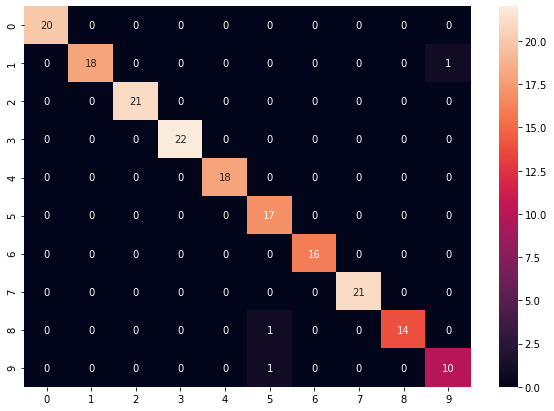

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn

print(f"The best model using Accuracy was {models[46]}")

y_pred = models[46].predict(x_test)

print(f"Test perofrmance") 
print(f"{classification_report(y_test, y_pred)}")

cm_lr = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm_lr, annot=True)

Ainda aqui vamos tentar comprar esses resultados com os resultados de um modelo com os mesmos parâmetros mas treinando com dados não normalizados para ver o que acontece de diferente

In [19]:
train_nn, test_nn = train_test_split(data, test_size=0.1,  random_state=1)
x_train_nn = train_nn.loc[:, train.columns != 'target']
y_train_nn = train_nn['target']
x_test_nn = test_nn.loc[:, test.columns != 'target']
y_test_nn = test_nn['target']

for train_set, val_set in kf.split(train_nn):
    clf_lr_nn =  LogisticRegression(multi_class='multinomial',
            penalty='l2', #lasso regression
            solver='newton-cg',
            max_iter=10,
            C=100).fit(x_train_nn.to_numpy()[train_set], y_train_nn.iloc[train_set])


The best model using Accuracy was LogisticRegression(C=100, max_iter=10, multi_class='multinomial',
                   solver='newton-cg')
Test perofrmance
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.94      0.89      0.92        19
         2.0       1.00      1.00      1.00        21
         3.0       1.00      1.00      1.00        22
         4.0       0.95      1.00      0.97        18
         5.0       0.89      0.94      0.91        17
         6.0       1.00      1.00      1.00        16
         7.0       1.00      1.00      1.00        21
         8.0       1.00      0.93      0.97        15
         9.0       0.91      0.91      0.91        11

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



<AxesSubplot:>

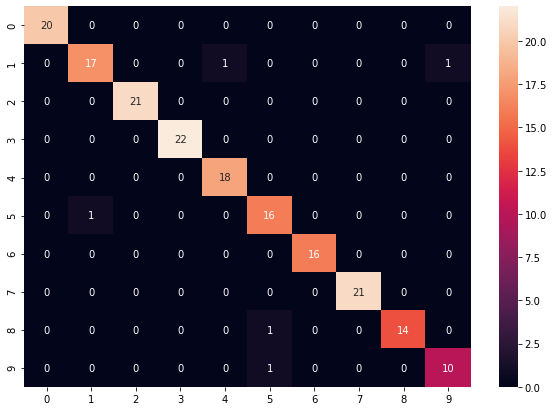

In [20]:
print(f"The best model using Accuracy was {clf_lr_nn}")

y_pred = clf_lr_nn.predict(x_test_nn)

print(f"Test perofrmance") 
print(f"{classification_report(y_test_nn, y_pred)}")

cm_lr = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm_lr, annot=True)

Como podemos ver de fato a normalização teve um impacto final positivo, ainda que não extraordinário, algo que deve favorecer isso é os numeros do dataser estarem na mesma escala

### Test OneVsOne Classifier <a name="title10" />

Como pode ser visto abaixo o modelo também possui resultados bem altos, olhando número a número pode-se notar um desempenho levemente superior (cosndierando o F1 Score) no número 9 e no número 1, tendo tanto precisão quanto recall melhores

The best model using Accuracy was OneVsOneClassifier(estimator=LinearSVC(C=10, loss='hinge', max_iter=100,
                                       random_state=0))
Test perofrmance
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        19
         2.0       1.00      1.00      1.00        21
         3.0       1.00      1.00      1.00        22
         4.0       1.00      1.00      1.00        18
         5.0       0.89      1.00      0.94        17
         6.0       1.00      1.00      1.00        16
         7.0       1.00      1.00      1.00        21
         8.0       1.00      0.93      0.97        15
         9.0       1.00      0.91      0.95        11

    accuracy                           0.99       180
   macro avg       0.99      0.98      0.99       180
weighted avg       0.99      0.99      0.99       180



<AxesSubplot:>

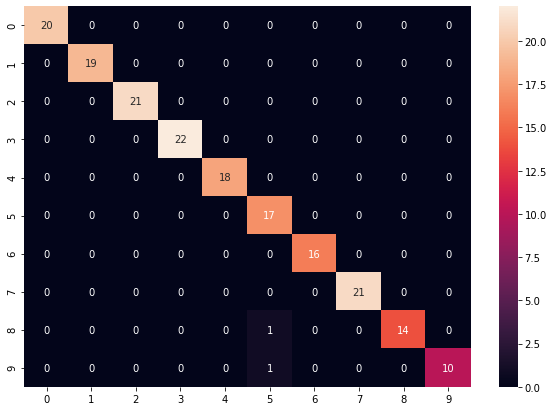

In [21]:
print(f"The best model using Accuracy was {models2[6]}")

y_pred = models2[6].predict(x_test)

print(f"Test perofrmance") 
print(f"{classification_report(y_test, y_pred)}")

cm_oo = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm_oo, annot=True)

## Conclusão

Como apresentado acima os dois métodos tiveram resultados muito semelhantes no final, com o segundo método sendo levemente superior, mas ainda sim com números muito altos. 

A ideia principal era a comparação entre dois métodos de classificação, um sendo o LogisticRegression com multiplas classes e o segundo a aplicação de One Vs One com o método de classicação binário LinearSCV, para esse dataset usando o KFold os resultados acabaram sendo muito próximos e com bons resultados, ainda que os algoritmos sejam tão distintos. 

Por fim um último comentário, a aleatoriedade do desbalanceamento das classes pode ter favorecido um pouco os bons números no teste, que foram iguais ou superiores até que o de validação, já que o que aparenta ser a classe mais problemática (o 9) foi a com menor quantidade de testes.